# Notebook: Mole Classification

This notebook implements the Google MobileNet model to classify skin lesion images for melanoma using transfer learning.

### Datasets


**Dataset used**: [Collected Medical Images of skin lesions - split in melanoma and inconspicuous](https://www.kaggle.com/drscarlat/melanoma)  
Data in dataset from: [HAM10000 Skin Lesion Challenge](https://www.kaggle.com/kmader/skin-cancer-mnist-ham10000)  
Origin of data: [ISIC Archive](https://www.isic-archive.com) 

### Literature

[Stanford/Nature](https://cs.stanford.edu/people/esteva/nature/)  
[Skin Cancer Classification using CNN](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6231861/)  
[Machine Learning for ISIC Skin Cancer Classification Challenge](https://hackernoon.com/machine-learning-for-isic-skin-cancer-classification-challenge-part-1-ccddea4ec44a) 
[Documentation Tensorflow Transfer Learning](https://www.tensorflow.org/tutorials/images/transfer_learning)  
Model structure taken from [example implementation for given dataset](https://www.kaggle.com/gabrielmv/melanoma-classifier-mobilenet)

In [1]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from tensorflow.keras.applications.mobilenet import MobileNet, preprocess_input
import numpy as np
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

Defining parameters for given dataset.  
Adjust according to given data.

In [2]:
training_path = 'datasets/train_sep'
validation_path = 'datasets/valid'
test_path = 'datasets/test'

train_batch_size = 16
val_batch_size = 16
test_batch_size = 16

train_steps = np.ceil(10682 / train_batch_size) # number training samples
val_steps = np.ceil(3562 / val_batch_size) # number validation samples
test_steps = np.ceil(3561 / test_batch_size) # number test samples

target_size = (224, 224)

Generate the image batches using [Keras preprocessing image library](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator).

In [4]:
train_batches = ImageDataGenerator(rescale = 1./255).flow_from_directory(training_path,
                                    target_size = target_size,
                                    batch_size = train_batch_size,
                                    class_mode = 'categorical')

valid_batches = ImageDataGenerator(rescale = 1./255).flow_from_directory(validation_path,
                                        target_size = target_size,
                                        batch_size = val_batch_size,
                                        class_mode = 'categorical')

test_batches = ImageDataGenerator(rescale = 1./255).flow_from_directory(test_path,
                                          target_size = target_size,
                                          batch_size = test_batch_size,
                                          class_mode = 'categorical',
                                          shuffle = False)

Found 10682 images belonging to 2 classes.
Found 3562 images belonging to 2 classes.
Found 3561 images belonging to 2 classes.


Add [callbacks](https://keras.io/callbacks/) for training process.  
Using _ReduceLROnPlateau_ to detect periods of no improvement and adjust the learning rate. Can improve the results.  
Using _EarlyStopping_ to stop training when no improvement possible.

In [3]:
callbacks = [
        ReduceLROnPlateau(monitor = 'val_loss', factor = 0.2, patience = 8, verbose = 1, mode = 'min', min_lr = 0.00001),
        EarlyStopping(monitor = 'val_loss', min_delta = 1e-10, patience = 15, verbose = 1)
        ]

Load MobileNet

In [5]:
mobile = MobileNet()

Replace last 6 layers with a dropout and dense layer to transfer MobileNet model to melanoma classification.

In [6]:
x = mobile.layers[-6].output
x = Dropout(0.5)(x)
predictions = Dense(2, activation='softmax')(x)    

Freeze MobileNet layers for learning process.

In [7]:
for layer in mobile.layers:
    layer.trainable = False

Define melanoma classification model.

In [8]:
model = Model(inputs = mobile.input, outputs = predictions)

Set model parameters for optimizer.

In [9]:
model.compile(Adam(), loss = 'categorical_crossentropy', metrics = ['accuracy'])

Train melanoma classification model.

In [10]:
model.fit_generator(train_batches,
                          steps_per_epoch = train_steps,
                          validation_data = valid_batches,
                          validation_steps = val_steps,
                          epochs = 5,
                          verbose = 1,
                          callbacks = callbacks)

Epoch 1/5
668/668 [==============================] - 203s 304ms/step - loss: 0.3477 - accuracy: 0.8712 - val_loss: 0.2239 - val_accuracy: 0.9284
Epoch 2/5
668/668 [==============================] - 230s 344ms/step - loss: 0.2696 - accuracy: 0.9006 - val_loss: 0.2702 - val_accuracy: 0.9203
Epoch 3/5
668/668 [==============================] - 217s 325ms/step - loss: 0.2600 - accuracy: 0.9063 - val_loss: 0.2429 - val_accuracy: 0.9278
Epoch 4/5
668/668 [==============================] - 210s 315ms/step - loss: 0.2505 - accuracy: 0.9065 - val_loss: 0.2402 - val_accuracy: 0.9293
Epoch 5/5
668/668 [==============================] - 193s 289ms/step - loss: 0.2563 - accuracy: 0.9022 - val_loss: 0.3295 - val_accuracy: 0.8871


Save model to disk. Can be necessary for testing or further usage without rerunning the training process after a kernel restart.

In [11]:
model.save('predict_melanoma.h5')

Run model with the test dataset.

In [12]:
test_labels = test_batches.classes
predictions = model.predict_generator(test_batches, steps = val_steps, verbose = 1)

223/223 [==============================] - 35s 158ms/step


Calculate false positive rate and true positive rate for all thresholds.  
Calculate Area under the ROC curve.

In [13]:
fpr, tpr, thresholds = roc_curve(test_labels, predictions[:,1])

In [14]:
auc_score = auc(fpr, tpr)
print(auc_score)

0.9591999507914376


PLOT resulting ROC-Curve

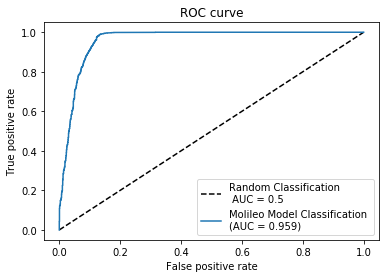

In [15]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--', label='Random Classification \n AUC = 0.5')
plt.plot(fpr, tpr, label='Molileo Model Classification \n(AUC = {:.3f})'.format(auc_score))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

Load model from file if it's not loaded. Otherwise can be skipped.

In [16]:
from tensorflow.keras.models import load_model
model = load_model('predict_melanoma.h5')

Convert model to tensorflow lite model. [Documentation](https://www.tensorflow.org/lite/convert/python_api)

In [17]:
import tensorflow as tf 
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

Save/Overwrite model in .tflite format.

In [18]:
open("../frontend_molileo/assets/predict_melanoma.tflite", "wb").write(tflite_model)

12804896